# Installs

In [2]:
%pip install opencv-python
%pip install tqdm
%pip install mlxtend
%pip install xgboost
%pip install lightgbm
%pip install opendatasets
%pip install tensorflow
%pip install keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [64]:
import cv2
import glob
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC,LinearSVC
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGB

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cvs
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import f1_score as f1s
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import log_loss as ll
from sklearn.metrics import classification_report as cr
from sklearn.metrics import RocCurveDisplay as rcd

import opendatasets as od
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Loading the Data

In [4]:
dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

Skipping, found downloaded files in ".\fruits" (use force=True to force download)


In [5]:
data_dir = './fruits/fruits-360_dataset/fruits-360'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/Training')
print(len(classes))

['LICENSE', 'papers', 'readme.md', 'Test', 'test-multiple_fruits', 'Training']
131


In [6]:
def getYourFruits(fruits,img_dim, split, print_n=False):
    images = []
    labels = []
    path = data_dir + "/" + split + "/"
    for i,f in enumerate(fruits):
        p = path + f
        j=0
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (img_dim, img_dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(i)
            j+=1
        if(print_n):
            print("There are " , j , " " , split.upper(), " images of " , fruits[i].upper())
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def getAllFruits():
    return os.listdir(data_dir + '/Training')


In [7]:
fruits_arr = getAllFruits()
len(fruits_arr)

131

In [8]:
X_train, y_train =  getYourFruits(fruits_arr,20,'Training')
X_test, y_test = getYourFruits(fruits_arr,20,'Test')

In [9]:
# flattening the 3D image array
scaler = SS()
X_train_scaled = scaler.fit_transform([i.flatten() for i in X_train])
X_test_scaled= scaler.transform([i.flatten() for i in X_test])

# Visualization

In [10]:
def plot_image_grid(X,y):
  fig, axs = plt.subplots(12,11,figsize=(12,12))
  fig.delaxes(axs[11][10])
  ind = np.unique(y,return_index=True)[1]
  n = 0
  for i in range(0, 12):
    for j in range(0, 11):
      if n==131:
        break
      axs[i, j].axis('off')
      axs[i, j].imshow(X[ind[n]])
      n += 1   

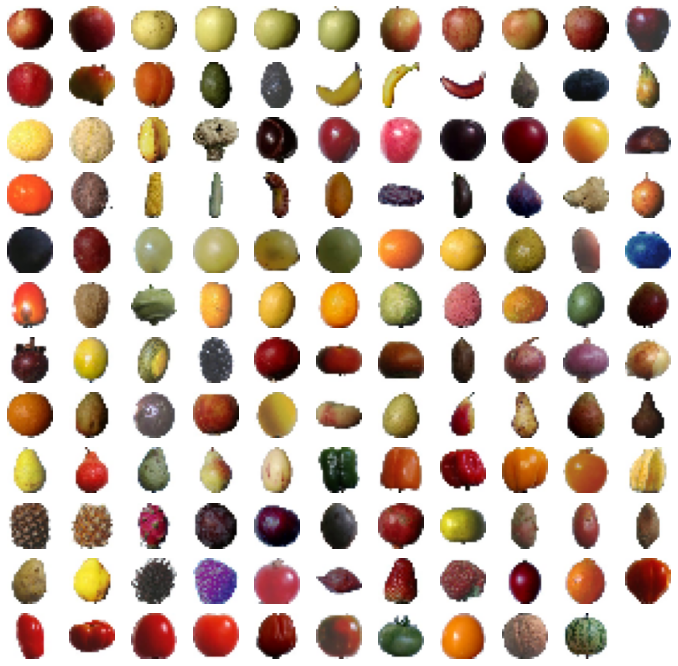

In [11]:
plot_image_grid(X_train,y_train)

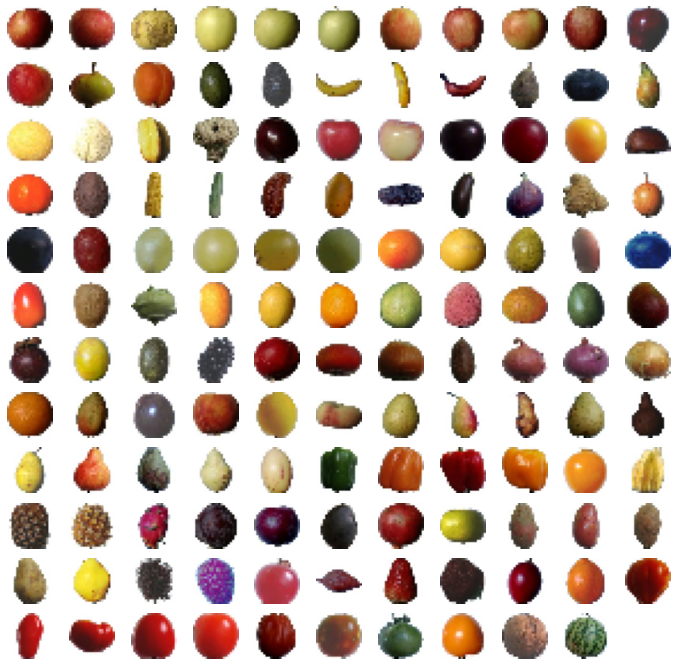

In [12]:
plot_image_grid(X_test,y_test)

# Principal Component Analysis

In [13]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits_arr[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits_arr[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')

    plt.xticks()
    plt.yticks()
    plt.show()


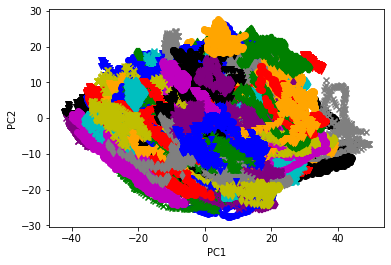

In [14]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train_scaled)
plotPrincipalComponents(dataIn2D, 2)

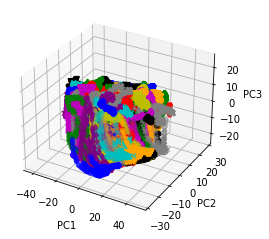

In [15]:
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train_scaled)
plotPrincipalComponents(dataIn3D, 3)

# Implementing various models using sklearn

## SVM

In [93]:
model1 = LinearSVC()
model1.fit(X_train_scaled, y_train) 
yptr1 = model1.predict(X_train_scaled) 
ypts1 = model1.predict(X_test_scaled) 
ypptr1 = model1.predict(X_train_scaled)
yppts1 = model1.predict(X_test_scaled)
print("SVM with linear kernel-")
print(f"Train: acc: {acs(y_train, yptr1)} f1: {f1s(y_train,yptr1,average='macro')}")
print(f"Test: acc: {acs(y_test, ypts1)} f1: {f1s(y_test,ypts1, average='macro')} ")

SVM with linear kernel-
Train: acc: 0.9995272705785027 f1: 0.9995195993874902
Test: acc: 0.8347584626234132 f1: 0.8271709959277895 


## KNN

In [16]:
model3 = KNC(n_neighbors=5)
model3.fit(X_train_scaled, y_train) 
yptr3 = model3.predict(X_train_scaled) 
ypts3 = model3.predict(X_test_scaled) 
ypptr3 = model3.predict(X_train_scaled)
yppts3 = model3.predict(X_test_scaled)
print("KNN with n_neighbors=5 -")
print(f"Train: acc: {acs(y_train, yptr3)} f1: {f1s(y_train,yptr3,average='macro')}")
print(f"Test: acc: {acs(y_test, ypts3)} f1: {f1s(y_test,ypts3, average='macro')}")

model4 = KNC(n_neighbors=15)
model4.fit(X_train_scaled, y_train) 
yptr4 = model4.predict(X_train_scaled) 
ypts4 = model4.predict(X_test_scaled)
ypptr4 = model4.predict(X_train_scaled)
yppts4 = model4.predict(X_test_scaled) 
print("KNN with n_neighbors= 15 -")
print(f"Train: acc: {acs(y_train, yptr4)} f1: {f1s(y_train,yptr4,average='macro')}")
print(f"Test: acc: {acs(y_test, ypts4)} f1: {f1s(y_test,ypts4, average='macro')}")



KNN with n_neighbors=5 -
Train: acc: 0.9989954499793181 f1: 0.9989469725629834
Test: acc: 0.878922778561354 f1: 0.874730241477949
KNN with n_neighbors= 15 -
Train: acc: 0.9941942917922354 f1: 0.9938245167772457
Test: acc: 0.8390779266572638 f1: 0.8331288585515777
KNN with n_neighbors= 25 -
Train: acc: 0.9841340187909945 f1: 0.9833126925534821 
Test: acc: 0.8064174894217208 f1: 0.7998883923597148 


In [17]:
model5 = KNC(n_neighbors=25)
model5.fit(X_train_scaled, y_train) 
yptr5 = model5.predict(X_train_scaled) 
ypts5 = model5.predict(X_test_scaled)
ypptr5 = model5.predict(X_train_scaled)
yppts5 = model5.predict(X_test_scaled) 
print("KNN with n_neighbors= 25 -")
print(f"Train: acc: {acs(y_train, yptr5)} f1: {f1s(y_train,yptr5,average='macro')} ")
print(f"Test: acc: {acs(y_test, ypts5)} f1: {f1s(y_test,ypts5, average='macro')} ")


KNN with n_neighbors= 25 -
Train: acc: 0.9841340187909945 f1: 0.9833126925534821 
Test: acc: 0.8064174894217208 f1: 0.7998883923597148 


## Random Forest

In [20]:
model6 = RFC(n_estimators= 10)
model6.fit(X_train_scaled, y_train) 
yptr6 = model6.predict(X_train_scaled) 
ypts6 = model6.predict(X_test_scaled) 
ypptr6 = model6.predict(X_train_scaled)
yppts6 = model6.predict(X_test_scaled)
print("Random Forest-")
print(f"Train: acc: {acs(y_train, yptr6)} f1: {f1s(y_train,yptr6,average='macro')}")
print(f"Test: acc: {acs(y_test, ypts6)} f1: {f1s(y_test,ypts6, average='macro')} ")


model7 = RFC(n_estimators= 100,max_features= 0.025,criterion='gini')
model7.fit(X_train_scaled, y_train) 
yptr7 = model7.predict(X_train_scaled) 
ypts7 = model7.predict(X_test_scaled)
ypptr7 = model7.predict(X_train_scaled)
yppts7 = model7.predict(X_test_scaled) 
print("Random Forest hypertuned-")
print(f"Train: acc: {acs(y_train, yptr7)} f1: {f1s(y_train,yptr7,average='macro')} ")
print(f"Test: acc: {acs(y_test, ypts7)} f1: {f1s(y_test,ypts7, average='macro')} ")


Random Forest-
Train: acc: 1.0 f1: 1.0
Test: acc: 0.9010930888575458 f1: 0.8950767465235832 
Random Forest hypertuned-
Train: acc: 1.0 f1: 1.0 
Test: acc: 0.9483868124118476 f1: 0.9445741213343447 


## LightGBM

In [19]:
model8 = LGB(objective='multiclass')
model8.fit(X_train_scaled, y_train) 
yptr8 = model8.predict(X_train_scaled) 
ypts8 = model8.predict(X_test_scaled) 
ypptr8 = model8.predict(X_train_scaled)
yppts8 = model8.predict(X_test_scaled)
print("LightGBM-")
print(f"Train: acc: {acs(y_train, yptr8)} f1: {f1s(y_train,yptr8,average='macro')} ")
print(f"Test: acc: {acs(y_test, ypts8)} f1: {f1s(y_test,ypts8, average='macro')} ")


model9 = LGB(objective='multiclass',n_estimators= 4,num_leaves= 6,min_child_samples=16,learning_rate= 0.48)
model9.fit(X_train_scaled, y_train) 
yptr9 = model9.predict(X_train_scaled) 
ypts9 = model9.predict(X_test_scaled)
ypptr9 = model9.predict(X_train_scaled)
yppts9 = model9.predict(X_test_scaled) 
print("LightGBM hypertuned-")
print(f"Train: acc: {acs(y_train, yptr9)} f1: {f1s(y_train,yptr9,average='macro')}")
print(f"Test: acc: {acs(y_test, ypts9)} f1: {f1s(y_test,ypts9, average='macro')}")


LightGBM-
Train: acc: 0.30485138568811676 f1: 0.29987427332454014 
Test: acc: 0.24444640338504936 f1: 0.23555054233285433 
LightGBM hypertuned-
Train: acc: 0.4425781480824913 f1: 0.4422053573744064
Test: acc: 0.3478490832157969 f1: 0.3402383772721895


## CNN

In [33]:
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Flatten, BatchNormalization
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.metrics import mean_squared_error

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [83]:
model10=Sequential()
model10.add(Conv2D(32, (3, 3),input_shape=(20, 20, 3)))
model10.add(Activation('relu'))
model10.add(MaxPooling2D(pool_size=(1,1)))

model10.add(Conv2D(32,(3,3)))
model10.add(Activation('relu'))
model10.add(MaxPooling2D(pool_size=(2,2)))

model10.add(Conv2D(32,(3,3)))
model10.add(Activation('relu'))
model10.add(MaxPooling2D(pool_size=(2,2)))

model10.add(Flatten())

model10.add(Dense(64))
model10.add(Activation('relu'))
model10.add(Dense(131))
model10.add(Activation('softmax'))

In [84]:
y=pd.get_dummies(y_test)

In [85]:
y_train1=pd.get_dummies(y_train)

In [86]:
model10.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model10.fit(X_train, y_train1, epochs=10, 
                    validation_data=(X_test, y))

Epoch 1/10
2116/2116 [==============================] - 38s 18ms/step - loss: 0.0280 - accuracy: 0.6649 - val_loss: 0.0107 - val_accuracy: 0.8407
Epoch 2/10
2116/2116 [==============================] - 38s 18ms/step - loss: 0.0028 - accuracy: 0.9701 - val_loss: 0.0081 - val_accuracy: 0.9028
Epoch 3/10
2116/2116 [==============================] - 36s 17ms/step - loss: 0.0019 - accuracy: 0.9844 - val_loss: 0.0088 - val_accuracy: 0.9157
Epoch 4/10
2116/2116 [==============================] - 40s 19ms/step - loss: 0.0015 - accuracy: 0.9882 - val_loss: 0.0064 - val_accuracy: 0.9290
Epoch 5/10
2116/2116 [==============================] - 38s 18ms/step - loss: 0.0012 - accuracy: 0.9923 - val_loss: 0.0086 - val_accuracy: 0.9271
Epoch 6/10
2116/2116 [==============================] - 39s 18ms/step - loss: 0.0011 - accuracy: 0.9923 - val_loss: 0.0093 - val_accuracy: 0.9318
Epoch 7/10
2116/2116 [==============================] - 39s 18ms/step - loss: 9.0566e-04 - accuracy: 0.9943 - val_loss: 0.00

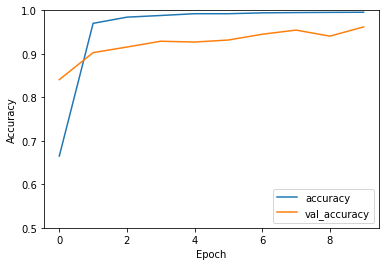

In [87]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

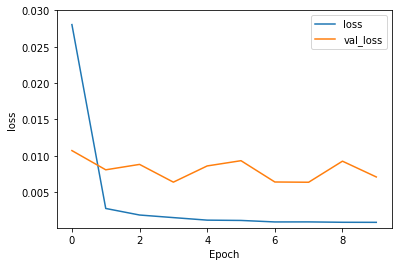

In [92]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0001, 0.03])
plt.legend(loc='upper right')

# ROC values

In [95]:
ypptd1=pd.get_dummies(yppts1)
ypptd3=pd.get_dummies(yppts3)
ypptd4=pd.get_dummies(yppts4)
ypptd5=pd.get_dummies(yppts5)
ypptd6=pd.get_dummies(yppts6)
ypptd7=pd.get_dummies(yppts7)
ypptd8=pd.get_dummies(yppts8)
ypptd9=pd.get_dummies(yppts9)

In [97]:
print("ROC for SVM with linear krnel:",ras(y,ypptd1))
print("ROC for KNN with n_neighbor=5:",ras(y,ypptd3))
print("ROC for KNN with n_neighbor=15:",ras(y,ypptd4))
print("ROC for KNN with n_neighbor=25:",ras(y,ypptd5))
print("ROC for Random Forest:",ras(y,ypptd6))
print("ROC for Random Forest hypertuned:",ras(y,ypptd7))
print("ROC for LightGBM:",ras(y,ypptd8))
print("ROC for LightGBM hypertuned:",ras(y,ypptd9))

ROC for SVM with linear krnel: 0.9136631573359937
ROC for KNN with n_neighbor=5: 0.9368687889783012
ROC for KNN with n_neighbor=15: 0.916487708825462
ROC for KNN with n_neighbor=25: 0.9003824245991423
ROC for Random Forest: 0.9483793418395507
ROC for Random Forest hypertuned: 0.9724889641324203
ROC for LightGBM: 0.524102238138372
ROC for LightGBM hypertuned: 0.6678905060928453
